In [ ]:
#!pip install category_encoders

In [259]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as st
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler 
from category_encoders.target_encoder import TargetEncoder

from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor

%matplotlib inline

# Подготовка дынных

In [207]:
df = pd.read_csv('final_data_new.csv')
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
print(df.shape)
df.head()

(4666, 93)


,t вып-обр,t обработка,t под током,t продувка,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,температура первая,температура последняя,Ar (интенс.),эл. энергия (интенс.),произв жидкая сталь,произв количество обработок,расход газ Ar,сыпуч кокс пыль УСТК,сыпуч кокс. мелочь КМ1,ферспл CaC2,ферспл Mn5Si65Al0.5,ферспл SiMn18,ферспл фх850А,эл. энергия,химсталь первый Al_1,химсталь первый C_1,химсталь первый Cr_1,химсталь первый Cu_1,химсталь первый Mn_1,химсталь первый Mo_1,химсталь первый N_1,химсталь первый Ni_1,химсталь первый P_1,химсталь первый S_1,химсталь первый Si_1,химсталь первый Ti_1,химсталь первый V_1,химсталь последний Al,химсталь последний C,химсталь последний Ca,химсталь последний Cr,химсталь последний Cu,...,химшлак первый R_1,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2,химшлак последний Al2O3,химшлак первый Al2O3_1,136 RE,54E1,60E1,UIC54,НЕТ,ОР50,ОР65,Р50,Р65,Рельсы трамвайные,Шар заг d шара 100 мм 2 гр.,"Шар заг d шара 80-100 мм 2,3 гр.",Шар заг d шара 80-100 мм 4 гр.,Шары мелющие d 80-100 мм,Швеллер 40У,900А,G2HH,R260,R350HT,НХ,С255,Ш2.2,Ш2Л,Э73Ф,Э76,Э76Ф,Э76ХАФ,Э76ХФ,Э90ХАФ,сыпуч известь РП,химшлак первый SiO2_1
0,43.0,44.166667,21.683333,44.166667,0.481645,0.196138,0.201184,0.251281,1563.0,1588.0,14.163539,13769.100692,113.9,1.0,20.545,0.10,0.464,0.03,0.303,0.307,0.349000,4976.0,0.001,0.450,0.524,0.110,0.223,0.008,0.011,0.151,0.008,0.030,0.382,0.002,0.002,0.003,0.832,0.00050,0.692,0.110,...,1.8,56.2,0.4,7.8,0.07,2.2,26.0,5.7,3.8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.379,26.8
1,18.0,42.016667,20.016667,41.850000,0.339285,0.075060,0.066049,0.068946,1577.0,1590.0,8.060323,12550.541216,110.8,1.0,11.224,0.05,0.359,0.02,0.079,0.101,0.135000,4187.0,0.001,0.525,0.350,0.119,0.740,0.008,0.008,0.080,0.011,0.024,0.519,0.002,0.003,0.003,0.769,0.00032,0.415,0.121,...,2.3,54.8,0.8,6.1,0.09,2.4,23.2,3.2,2.7,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,NaN,25.6
2,9.0,43.850000,18.950000,43.850000,0.433960,0.117998,0.175658,0.089606,1586.0,1596.0,10.810282,12012.664908,113.4,1.0,15.771,0.05,0.486,0.02,0.066,0.265,0.208581,3794.0,0.001,0.425,0.071,0.090,0.736,0.005,0.010,0.058,0.011,0.019,0.245,0.001,0.002,0.002,0.755,0.00020,0.071,0.090,...,2.4,54.8,0.6,11.6,0.16,2.1,26.1,4.7,4.8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,20.4
3,7.0,46.716667,19.216667,46.716667,0.548870,0.117998,0.199137,0.087354,1607.0,1594.0,9.288334,11908.412836,115.9,1.0,14.464,0.05,0.627,0.02,0.054,0.300,0.208581,3814.0,0.001,0.348,0.065,0.096,0.689,0.005,0.010,0.062,0.008,0.021,0.226,0.001,0.001,0.003,0.770,0.00020,0.066,0.095,...,2.3,51.9,0.5,10.3,0.15,2.1,24.2,5.4,4.9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,23.8
4,26.0,42.050000,19.883333,42.050000,0.402655,0.168487,0.176548,0.153988,1565.0,1588.0,18.348157,13609.388097,116.9,1.0,25.718,0.05,0.417,0.02,0.164,0.266,0.289000,4510.0,0.002,0.452,0.280,0.096,0.642,0.006,0.009,0.065,0.007,0.018,0.434,0.002,0.002,0.003,0.771,0.00030,0.419,0.097,...,2.2,54.5,0.3,14.0,0.14,2.1,26.6,5.2,5.3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,NaN,22.4


In [208]:
future_col = [col for col in df.columns if 'последний' in col or 'последняя' in col]
target_col = ['химшлак последний Al2O3', 'химшлак последний CaO', 'химшлак последний R', 'химшлак последний SiO2']
present_col = [col for col in df.columns if 'последний' not in col and 'последняя' not in col]
not_target_col = [col for col in df.columns if col not in target_col]

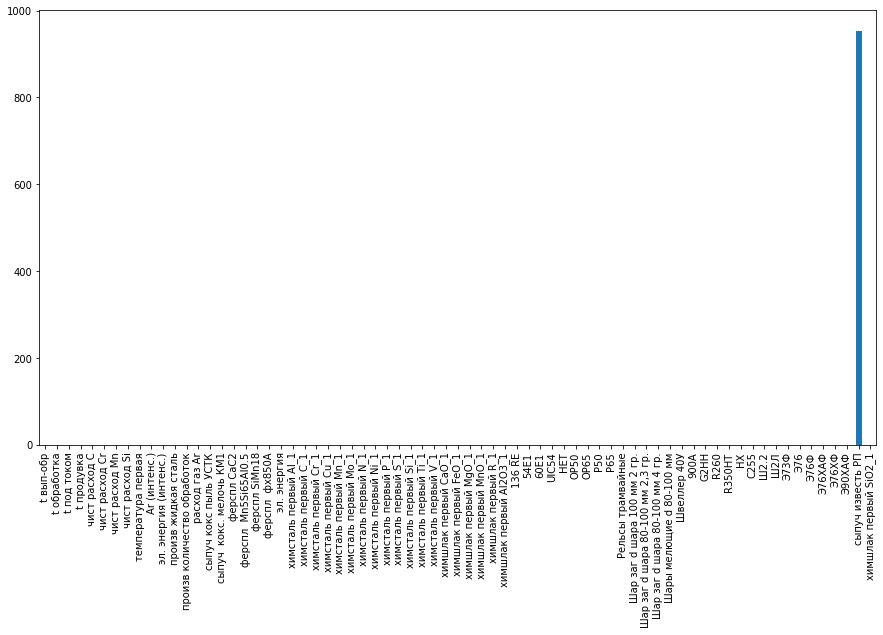

In [209]:
df[present_col].isna().sum().plot(kind = 'bar', figsize = (15,8))

In [210]:
data = df[df['сыпуч известь РП'].notnull()]
data.shape

(3712, 93)

In [211]:
scaler = StandardScaler()
scaler.fit(data)
data1 = pd.DataFrame(scaler.transform(data), columns = data.columns)

# Тестирование моделей

### Посмотрим на общий резульат моделей без улучшений

In [212]:
X = data1.drop(['сыпуч известь РП'], axis = 1)
y = data['сыпуч известь РП'].values

In [213]:
def get_score(target, name, model, X_train, X_test, y_train, y_test, status):
  model.fit(X_train, y_train)
  score_train =model.score(X_train, y_train) 
  score_test = model.score(X_test, y_test)

  if status:
    df_new = pd.DataFrame(model.feature_importances_, index = X_train.columns, columns = ['importance'])
    df_new[df_new['importance']>0].sort_values(by = 'importance').plot(kind = 'bar', title = f'{name} model and {target} columns')
    plt.show()

  cross_score = cross_val_score(model, X_test, y_test, cv=5)

  return score_train, score_test, cross_score

In [214]:
def get_data(X, y):
  X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.33, random_state=42)

  return  X_train, X_test, y_train, y_test 

In [215]:
mls = {
        'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0), 
        'linear': LinearRegression(), 'RandomForestRegressor':RandomForestRegressor(max_depth=2, random_state=0),
        'LassoCV': LassoCV(), 'Ridge': RidgeCV(), 'ElasticNetCV': ElasticNetCV(),
       'ExtraTreesRegressor': ExtraTreesRegressor(n_estimators=100, random_state=0)
        }

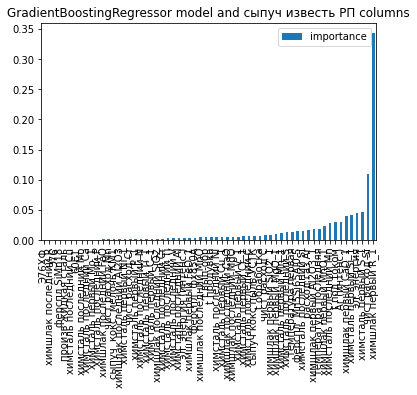

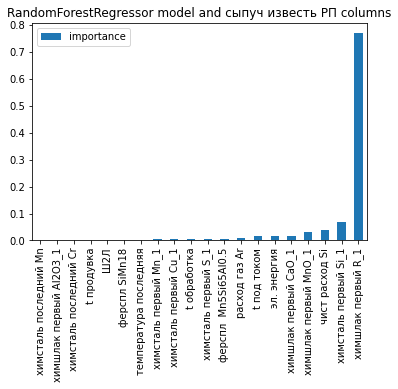

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002381455211697414, tolerance: 0.0012818386307692309
  tol, rng, random, positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005836369442913103, tolerance: 0.0012818386307692309
  tol, rng, random, positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022903769574783794, tolerance: 0.0012818386307692309
  tol, rng, random, positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You

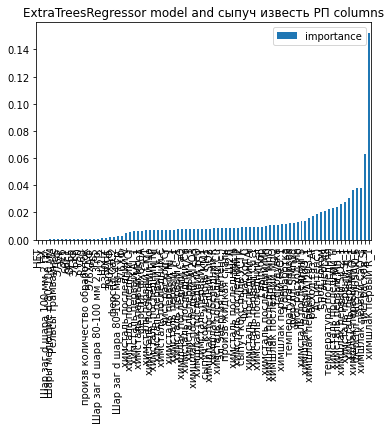

In [216]:
dict_results = {}
status = False

for col in ['сыпуч известь РП']:
  X_train, X_test, y_train, y_test = get_data(X,y)
  dict_results[col] = {}
  for name, model in mls.items():
    if name not in ['linear', 'LassoCV', 'Ridge', 'ElasticNetCV']:
      status = True
    else:
      status = False

    results = get_score(col, name, model, X_train,  X_test, y_train, y_test, status)
    dict_results[col][name] = {'score_train' : results[0].round(3),'score_test' : results[1].round(3),
                               'cross_score': results[2].mean().round(3)}

In [217]:
for k,v in dict_results.items():
  print(k)
  for ki,vi in v.items():
    print(ki, vi)
  print('-'*30)

сыпуч известь РП
GradientBoostingRegressor {'score_train': 0.726, 'score_test': 0.505, 'cross_score': 0.467}
linear {'score_train': 0.556, 'score_test': -5.717239692873646e+22, 'cross_score': -1.2422010440651986e+23}
RandomForestRegressor {'score_train': 0.387, 'score_test': 0.326, 'cross_score': 0.311}
LassoCV {'score_train': 0.553, 'score_test': 0.458, 'cross_score': 0.387}
Ridge {'score_train': 0.558, 'score_test': 0.44, 'cross_score': 0.401}
ElasticNetCV {'score_train': 0.553, 'score_test': 0.458, 'cross_score': 0.387}
ExtraTreesRegressor {'score_train': 1.0, 'score_test': 0.501, 'cross_score': 0.422}
------------------------------


In [121]:
def encode_categorial(name_scaler, scaler, data, y = None, return_scaler = False):
    if name_scaler != 'TargetEncoder':
        if not return_scaler:
            return data[categorical_cols].apply(lambda x: scaler.fit_transform(x.astype(str)))
        else:
            return data[categorical_cols].apply(lambda x: scaler.fit_transform(x.astype(str))), scaler
    else:
        if not return_scaler:
            return scaler.fit_transform(data[categorical_cols], y)
        else:
            return scaler.fit_transform(data[categorical_cols], y), scaler
    
def encode_number(name_scaler, scaler, data, return_scaler = False):
    if name_scaler == 'Not scaled':
        if not return_scaler:
            return data
        else:
            return data, scaler
    else:
        if not return_scaler:
            return scaler.fit_transform(data)
        else:
            return scaler.fit_transform(data), scaler

In [220]:
mls = {
        'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0), 
        'linear': LinearRegression(), 'RandomForestRegressor':RandomForestRegressor(max_depth=2, random_state=0),
        'LassoCV': LassoCV(), 'RidgeCV': RidgeCV(), 'ElasticNetCV': ElasticNetCV(),
       'ExtraTreesRegressor': ExtraTreesRegressor(n_estimators=100, random_state=0)
        }

scalers = {'StandardScaler': StandardScaler(), 'MinMaxScaler': MinMaxScaler(),
           'RobustScaler': RobustScaler(), 'Normalizer': Normalizer(), 'Not scaled': 0}

mlss = []


X = data.drop(['сыпуч известь РП'], axis = 1)
y = data['сыпуч известь РП'].values

for idd, (name_ml, ml) in enumerate(mls.items()):
  print(name_ml)
  data_new = pd.DataFrame()
        
  for name_scaler, scaler in scalers.items():
      data_new = encode_number(name_scaler, scaler, X)

      X_train, X_test, y_train, y_test = train_test_split(data_new, y, test_size=0.33, random_state=42, shuffle = True)
      model = ml.fit(X_train, y_train)
        
      mlss.append([name_ml, model, 'r2', name_scaler, round(model.score(X_train, y_train),3),
                     round(model.score(X_test, y_test),3),
                     cross_val_score(model, X_test, y_test, cv=5)])

In [230]:
for i in mlss:
  print(i[0],  i[3], i[4], i[5], i[6].mean().round(3))

GradientBoostingRegressor StandardScaler 0.726 0.505 0.467
GradientBoostingRegressor MinMaxScaler 0.726 0.504 0.467
GradientBoostingRegressor RobustScaler 0.726 0.504 0.464
GradientBoostingRegressor Normalizer 0.671 0.436 0.378
GradientBoostingRegressor Not scaled 0.726 0.504 0.466
linear StandardScaler 0.557 -4.958503227383214e+23 -2.3885697857646245e+25
linear MinMaxScaler 0.547 -1.0155744492597406e+23 -6.297036439946748e+22
linear RobustScaler 0.559 0.434 0.377
linear Normalizer 0.554 0.121 0.386
linear Not scaled 0.559 0.434 0.377
RandomForestRegressor StandardScaler 0.387 0.326 0.311
RandomForestRegressor MinMaxScaler 0.387 0.326 0.31
RandomForestRegressor RobustScaler 0.387 0.326 0.31
RandomForestRegressor Normalizer 0.382 0.298 0.246
RandomForestRegressor Not scaled 0.387 0.326 0.311
LassoCV StandardScaler 0.553 0.458 0.387
LassoCV MinMaxScaler 0.553 0.464 0.427
LassoCV RobustScaler 0.546 0.45 0.406
LassoCV Normalizer 0.367 0.323 0.315
LassoCV Not scaled 0.372 0.336 0.328
RidgeC

### Выбираем модели ElasticNetCV и GradientBoostingRegressor как основные для нашего решения. Начинаем подбор параметров

### ElasticNetCV 

In [231]:
X = data.drop(['сыпуч известь РП'], axis = 1)
y = data['сыпуч известь РП'].values

scaler = MinMaxScaler()
scaler.fit(X)

data1 = pd.DataFrame(scaler.transform(X), columns = X.columns)

X_train, X_test, y_train, y_test = train_test_split(data1, y, test_size=0.33, random_state=42, shuffle = True)

In [232]:
metrics = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']

In [ ]:
parameters = {"max_iter": [5,7,10, 15],
                      "n_alphas": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      "l1_ratio": np.arange(0.1, 1, 0.1)}

model2 = ElasticNetCV()
grid1 = GridSearchCV(model2, parameters,  cv=5, verbose=True,
                               n_jobs= -1)
grid1.fit(X_train, y_train) 
grid1.best_estimator_

In [234]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [255]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

dict_data = pd.DataFrame({
    'r2_train': [r2_score(y_train, grid1.predict(X_train)).round(6)],
    'r2_test': [r2_score(y_test, grid1.predict(X_test)).round(6)],
    'MAE': [mean_absolute_error(y_test, grid1.predict(X_test)).round(6)],
    'MSE': [mean_squared_error(y_test, grid1.predict(X_test)).round(6)],
    'MAPE': [mean_absolute_percentage_error(y_test, grid1.predict(X_test)).round(6)]}, index = ['ElasticNetCV'])

dict_data

,r2_train,r2_test,MAE,MSE,MAPE
ElasticNetCV,0.538287,0.463454,0.04325,0.003161,45.357225


### GradientBoostingRegressor

In [242]:

X = data.drop(['сыпуч известь РП'], axis = 1)
y = data['сыпуч известь РП'].values

scaler = StandardScaler()
scaler.fit(X)

data1 = pd.DataFrame(scaler.transform(X), columns = X.columns)

X_train, X_test, y_train, y_test = train_test_split(data1, y, test_size=0.33, random_state=42, shuffle = True)


parameters = {'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9],
                      'max_depth': [80, 90, 100, 110],
                      'max_features': [2, 3],
                      'min_samples_leaf': [3, 4, 5],
                      'min_samples_split': [8, 10, 12]}



model1 = GradientBoostingRegressor()
grid = GridSearchCV(model1, parameters,  cv=5, verbose=True,
                               n_jobs= -1)
grid.fit(X_train, y_train) 
grid.best_estimator_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  5.5min finished


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls',
                          max_depth=100, max_features=3, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [251]:
new = pd.DataFrame({
    'r2_train': [r2_score(y_train, grid.predict(X_train)).round(6)],
    'r2_test': [r2_score(y_test, grid.predict(X_test)).round(6)],
    'MAE': [mean_absolute_error(y_test, grid.predict(X_test)).round(6)],
    'MSE': [mean_squared_error(y_test, grid.predict(X_test)).round(6)],
    'MAPE': [mean_absolute_percentage_error(y_test, grid.predict(X_test)).round(6)]}, index = ['GradientBoostingRegressor'])
new

,r2_train,r2_test,MAE,MSE,MAPE
GradientBoostingRegressor,0.999182,0.467812,0.043127,0.003135,46.225863


In [264]:
grid1.best_estimator_

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
             l1_ratio=0.9, max_iter=15, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [270]:
estimators = [
    ('elasticNET', grid1.best_estimator_),
    ('GradBoost', grid.best_estimator_)
]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)
reg.fit(X_train, y_train) 

StackingRegressor(cv=None,
                  estimators=[('elasticNET',
                               ElasticNetCV(alphas=None, copy_X=True, cv=None,
                                            eps=0.001, fit_intercept=True,
                                            l1_ratio=0.9, max_iter=15,
                                            n_alphas=100, n_jobs=None,
                                            normalize=False, positive=False,
                                            precompute='auto',
                                            random_state=None,
                                            selection='cyclic', tol=0.0001,
                                            verbose=0)),
                              ('GradBoost',
                               GradientBoostingRegressor(alpha=0.9,
                                                         ccp_alpha=0.0,
                                                         cr...
                  final_estimator=RandomForestReg

In [271]:
new1 = pd.DataFrame({
    'r2_train': [r2_score(y_train, reg.predict(X_train)).round(6)],
    'r2_test': [r2_score(y_test, reg.predict(X_test)).round(6)],
    'MAE': [mean_absolute_error(y_test, reg.predict(X_test)).round(6)],
    'MSE': [mean_squared_error(y_test, reg.predict(X_test)).round(6)],
    'MAPE': [mean_absolute_percentage_error(y_test, reg.predict(X_test)).round(6)]}, index = ['Stacking'])
new1

,r2_train,r2_test,MAE,MSE,MAPE
Stacking,0.749526,0.407592,0.045529,0.00349,45.169896


In [272]:
all = pd.concat([dict_data, new, new1])
all

,r2_train,r2_test,MAE,MSE,MAPE
ElasticNetCV,0.538287,0.463454,0.043250,0.003161,45.357225
GradientBoostingRegressor,0.999182,0.467812,0.043127,0.003135,46.225863
Stacking,0.749526,0.407592,0.045529,0.003490,45.169896


## Предсказываем для популярной марки

In [286]:
popular_mark=data[data['Э76ХФ']==1]
X = popular_mark.drop(['Э76ХФ'], axis = 1)
y = X.loc[X.index,'сыпуч известь РП'].values

In [287]:
scaler = StandardScaler()
scaler.fit(X)

data1 = pd.DataFrame(scaler.transform(X), columns = X.columns)

X_train, X_test, y_train, y_test = train_test_split(data1, y, test_size=0.33, random_state=42, shuffle = True)

In [ ]:
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)
reg.fit(X_train, y_train) 

In [289]:
pred_df=pd.DataFrame({'true':y_test,'pred':reg.predict(X_test)})
pred_df

,true,pred
0,0.104,0.105093
1,0.085,0.085200
2,0.085,0.087418
3,0.107,0.103200
4,0.123,0.125500
...,...,...
847,0.149,0.150700
848,0.163,0.161390
849,0.133,0.133300
850,0.210,0.214300


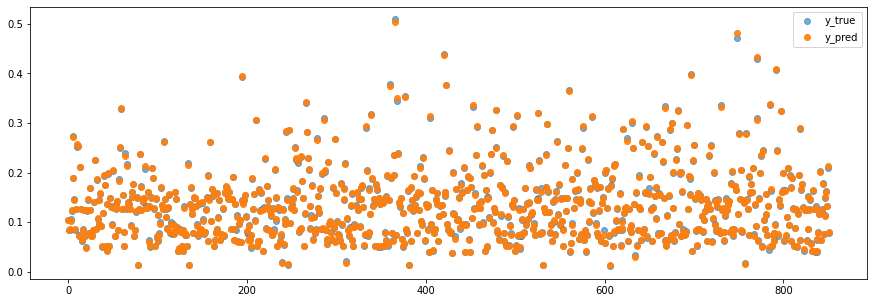

In [298]:
plt.figure(figsize=(15,5))
plt.scatter(range(pred_df.shape[0]),pred_df['true'], label = 'y_true', alpha = 0.6)
plt.scatter(range(pred_df.shape[0]),pred_df['pred'], label = 'y_pred', alpha = 0.9)
plt.legend()